##Imports & Setup

In [ ]:
!pip install opendatasets opencv-python-headless --quiet

#Standard Libraries
import os, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from PIL import Image
import cv2
import opendatasets as od
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from google.colab.patches import cv2_imshow

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import RandomErasing
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.mobile_optimizer import optimize_for_mobile

#Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Imports ok. PyTorch device:", "cuda" if torch.cuda.is_available() else "cpu")


Imports ok. PyTorch device: cuda


##Download & Combine Datasets

In [ ]:
#Download Datasets
od.download("https://www.kaggle.com/datasets/seroshkarim/cotton-leaf-disease-dataset")
od.download("https://www.kaggle.com/datasets/jayaprakashpondy/wheat-leaf-disease")

#Paths
wheat_path = "/content/wheat-leaf-disease/Dataset"
cotton_path = "/content/cotton-leaf-disease-dataset/cotton"
combined_path = "/content/combined_dataset"
os.makedirs(combined_path, exist_ok=True)

def move_images(src_folder, dest_folder):
    os.makedirs(dest_folder, exist_ok=True)
    for fname in os.listdir(src_folder):
        src = os.path.join(src_folder, fname)
        if os.path.isfile(src):
            shutil.copy(src, dest_folder)

#Wheat Classes
move_images(os.path.join(wheat_path, "Brown rust"), os.path.join(combined_path, "wheat_brown_rust"))
move_images(os.path.join(wheat_path, "Healthy"), os.path.join(combined_path, "wheat_healthy"))
move_images(os.path.join(wheat_path, "Loose Smut"), os.path.join(combined_path, "wheat_loose_smut"))

#Cotton Classes
for folder in os.listdir(cotton_path):
    move_images(os.path.join(cotton_path, folder), os.path.join(combined_path, f"cotton_{folder}"))

print("Combined dataset at:", combined_path)
for cls in sorted(os.listdir(combined_path)):
    p = os.path.join(combined_path, cls)
    if os.path.isdir(p):
        print(cls, ":", len([f for f in os.listdir(p) if os.path.isfile(os.path.join(p,f))]))


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ayesh0
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/seroshkarim/cotton-leaf-disease-dataset


100%|██████████| 181M/181M [00:00<00:00, 1.04GB/s]

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ayesh0
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jayaprakashpondy/wheat-leaf-disease


100%|██████████| 1.59G/1.59G [00:17<00:00, 100MB/s]



Combined dataset at: /content/combined_dataset
cotton_bacterial_blight : 448
cotton_curl_virus : 418
cotton_fussarium_wilt : 419
cotton_healthy : 426
wheat_brown_rust : 1256
wheat_healthy : 1658
wheat_loose_smut : 939


##Augmentations

In [ ]:
#Random Blur/Sharpen
class RandomBlurSharpen(object):
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img):
        if random.random() < self.p:
            arr = np.array(img)
            if random.random() < 0.5:
                arr = cv2.GaussianBlur(arr, (3,3), 0)
            else:
                kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
                arr = cv2.filter2D(arr, -1, kernel)
            return Image.fromarray(arr.astype(np.uint8))
        return img

#Gaussian Noise
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.03):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy = tensor + noise.to(tensor.device)
        return torch.clamp(noisy, 0., 1.)


##Data Loaders & Transforms

In [ ]:
#Hyperparameters
img_size = 128
batch_size = 32
num_workers = 2

#Transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25),
    RandomBlurSharpen(p=0.5),
    transforms.ToTensor(),
    AddGaussianNoise(mean=0., std=0.03),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
    RandomErasing(p=0.3, scale=(0.02,0.15), ratio=(0.3,3.3), value='random')
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

#Dataset + Split
dataset = datasets.ImageFolder(combined_path, transform=train_transforms)
class_names = dataset.classes
num_classes = len(class_names)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])
val_data.dataset.transform = val_transforms

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Train size:", len(train_data), "Val size:", len(val_data))


Device: cuda
Train size: 4389 Val size: 1098


##Class Weights & Combo Loss

In [ ]:
#Class Weights (inverse frequency)
train_targets = [label for _, label in train_data]
class_count = Counter(train_targets)
counts_list = [class_count[i] for i in range(num_classes)]
cw = torch.tensor([1.0 / c for c in counts_list], dtype=torch.float32)
cw = cw / cw.sum() * num_classes
cw = cw.to(device)
print("Class weights:", cw)

#Focal + CrossEntropy Combo Loss
def focal_loss(outputs, targets, alpha=1, gamma=2, weight=None):
    ce_loss = F.cross_entropy(outputs, targets, weight=weight, reduction='none')
    pt = torch.exp(-ce_loss)
    focal = alpha * (1 - pt) ** gamma * ce_loss
    return focal.mean()

def combined_loss(outputs, targets):
    focal_part = focal_loss(outputs, targets, alpha=1, gamma=2, weight=cw)
    ce_part = F.cross_entropy(outputs, targets, weight=cw)
    return 0.7 * focal_part + 0.3 * ce_part

criterion = combined_loss
print("Using Advanced Combo Loss: 0.7 Focal + 0.3 CrossEntropy")


Class weights: tensor([1.3210, 1.3957, 1.4040, 1.4254, 0.4575, 0.3728, 0.6236],
       device='cuda:0')
Using Advanced Combo Loss: 0.7 Focal + 0.3 CrossEntropy


##CNN Architecture

In [ ]:
class CropCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),

            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),

            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128,128,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.3),

            nn.Conv2d(128,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256,128), nn.ReLU(), nn.BatchNorm1d(128),
            nn.Dropout(0.4), nn.Linear(128, num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CropCNN(num_classes).to(device)
print(model)


CropCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.25, inplace=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

##MixUp & CutMix

In [ ]:
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size, C, H, W = x.size()
    index = torch.randperm(batch_size).to(x.device)

    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    x1 = np.clip(cx - cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y2 = np.clip(cy + cut_h // 2, 0, H)

    x[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

mixup_prob = 0.4
cutmix_prob = 0.3


##Optimizer & OneCycleLR

In [ ]:
epochs = 50
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=1e4
)
print("OneCycleLR ready — steps_per_epoch:", steps_per_epoch)


OneCycleLR ready — steps_per_epoch: 138


##Training Loop

In [ ]:
best_val_loss = np.inf
patience = 7
no_improve = 0

train_losses, val_losses, val_accs = [], [], []

for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", ncols=100)

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        r = random.random()
        if r < mixup_prob:
            mixed_x, y_a, y_b, lam = mixup_data(images, labels, alpha=0.4)
            outputs = model(mixed_x)
            loss = lam * combined_loss(outputs, y_a) + (1-lam) * combined_loss(outputs, y_b)
        elif r < mixup_prob + cutmix_prob:
            mixed_x, y_a, y_b, lam = cutmix_data(images.clone(), labels, alpha=1.0)
            outputs = model(mixed_x)
            loss = lam * combined_loss(outputs, y_a) + (1-lam) * combined_loss(outputs, y_b)
        else:
            outputs = model(images)
            loss = combined_loss(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        pbar.set_postfix({'loss': f"{running_loss / (pbar.n + 1):.4f}"})

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    #Validation
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = combined_loss(outputs, labels)
            val_running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    #Early Stopping & Save Best Model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'class_names': class_names
        }, "best_advanced_crop_model.pth")
        print("Saved best_advanced_crop_model.pth")
        no_improve = 0
    else:
        no_improve += 1
        print(f"No improvement: {no_improve}/{patience}")
        if no_improve >= patience:
            print("Early stopping triggered")
            break

print("Training finished. Best Val Loss:", best_val_loss)


Epoch 1/50: 100%|████████████████████████████████████| 138/138 [00:37<00:00,  3.67it/s, loss=0.9590]


Epoch 1 | Train Loss: 0.9590 | Val Loss: 1.4491 | Val Acc: 34.61%
Saved best_advanced_crop_model.pth


Epoch 2/50: 100%|████████████████████████████████████| 138/138 [00:35<00:00,  3.93it/s, loss=0.8191]


Epoch 2 | Train Loss: 0.8132 | Val Loss: 1.8086 | Val Acc: 27.96%
No improvement: 1/7


Epoch 3/50: 100%|████████████████████████████████████| 138/138 [00:34<00:00,  4.00it/s, loss=0.7549]


Epoch 3 | Train Loss: 0.7549 | Val Loss: 1.0702 | Val Acc: 54.74%
Saved best_advanced_crop_model.pth


Epoch 4/50: 100%|████████████████████████████████████| 138/138 [00:33<00:00,  4.06it/s, loss=0.7519]


Epoch 4 | Train Loss: 0.7465 | Val Loss: 1.2692 | Val Acc: 61.66%
No improvement: 1/7


Epoch 5/50: 100%|████████████████████████████████████| 138/138 [00:33<00:00,  4.13it/s, loss=0.7379]


Epoch 5 | Train Loss: 0.7379 | Val Loss: 0.7300 | Val Acc: 64.39%
Saved best_advanced_crop_model.pth


Epoch 6/50: 100%|████████████████████████████████████| 138/138 [00:35<00:00,  3.91it/s, loss=0.7411]


Epoch 6 | Train Loss: 0.7411 | Val Loss: 0.6258 | Val Acc: 64.48%
Saved best_advanced_crop_model.pth


Epoch 7/50: 100%|████████████████████████████████████| 138/138 [00:35<00:00,  3.84it/s, loss=0.6969]


Epoch 7 | Train Loss: 0.6969 | Val Loss: 0.5999 | Val Acc: 55.65%
Saved best_advanced_crop_model.pth


Epoch 8/50: 100%|████████████████████████████████████| 138/138 [00:34<00:00,  3.97it/s, loss=0.6507]


Epoch 8 | Train Loss: 0.6507 | Val Loss: 0.5236 | Val Acc: 61.20%
Saved best_advanced_crop_model.pth


Epoch 9/50: 100%|████████████████████████████████████| 138/138 [00:35<00:00,  3.89it/s, loss=0.6206]


Epoch 9 | Train Loss: 0.6206 | Val Loss: 0.6828 | Val Acc: 66.12%
No improvement: 1/7


Epoch 10/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.84it/s, loss=0.5991]


Epoch 10 | Train Loss: 0.5991 | Val Loss: 0.3742 | Val Acc: 71.49%
Saved best_advanced_crop_model.pth


Epoch 11/50: 100%|███████████████████████████████████| 138/138 [00:37<00:00,  3.73it/s, loss=0.5913]


Epoch 11 | Train Loss: 0.5870 | Val Loss: 0.4119 | Val Acc: 68.85%
No improvement: 1/7


Epoch 12/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.84it/s, loss=0.5917]


Epoch 12 | Train Loss: 0.5917 | Val Loss: 0.5546 | Val Acc: 55.65%
No improvement: 2/7


Epoch 13/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  4.00it/s, loss=0.5591]


Epoch 13 | Train Loss: 0.5591 | Val Loss: 0.4600 | Val Acc: 72.86%
No improvement: 3/7


Epoch 14/50: 100%|███████████████████████████████████| 138/138 [00:36<00:00,  3.83it/s, loss=0.5675]


Epoch 14 | Train Loss: 0.5634 | Val Loss: 0.3889 | Val Acc: 83.61%
No improvement: 4/7


Epoch 15/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.89it/s, loss=0.5139]


Epoch 15 | Train Loss: 0.5139 | Val Loss: 0.3824 | Val Acc: 79.23%
No improvement: 5/7


Epoch 16/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  3.99it/s, loss=0.5382]


Epoch 16 | Train Loss: 0.5343 | Val Loss: 0.3097 | Val Acc: 85.61%
Saved best_advanced_crop_model.pth


Epoch 17/50: 100%|███████████████████████████████████| 138/138 [00:33<00:00,  4.09it/s, loss=0.5212]


Epoch 17 | Train Loss: 0.5174 | Val Loss: 0.5129 | Val Acc: 67.67%
No improvement: 1/7


Epoch 18/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  4.01it/s, loss=0.4855]


Epoch 18 | Train Loss: 0.4820 | Val Loss: 0.2176 | Val Acc: 87.70%
Saved best_advanced_crop_model.pth


Epoch 19/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.88it/s, loss=0.4945]


Epoch 19 | Train Loss: 0.4945 | Val Loss: 0.2271 | Val Acc: 86.89%
No improvement: 1/7


Epoch 20/50: 100%|███████████████████████████████████| 138/138 [00:33<00:00,  4.15it/s, loss=0.4207]


Epoch 20 | Train Loss: 0.4207 | Val Loss: 0.2119 | Val Acc: 90.35%
Saved best_advanced_crop_model.pth


Epoch 21/50: 100%|███████████████████████████████████| 138/138 [00:33<00:00,  4.17it/s, loss=0.4358]


Epoch 21 | Train Loss: 0.4358 | Val Loss: 0.2016 | Val Acc: 89.71%
Saved best_advanced_crop_model.pth


Epoch 22/50: 100%|███████████████████████████████████| 138/138 [00:33<00:00,  4.07it/s, loss=0.3771]


Epoch 22 | Train Loss: 0.3771 | Val Loss: 0.2242 | Val Acc: 88.80%
No improvement: 1/7


Epoch 23/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  4.05it/s, loss=0.4384]


Epoch 23 | Train Loss: 0.4384 | Val Loss: 0.1625 | Val Acc: 87.34%
Saved best_advanced_crop_model.pth


Epoch 24/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  4.05it/s, loss=0.4107]


Epoch 24 | Train Loss: 0.4078 | Val Loss: 0.1878 | Val Acc: 91.07%
No improvement: 1/7


Epoch 25/50: 100%|███████████████████████████████████| 138/138 [00:33<00:00,  4.13it/s, loss=0.4345]


Epoch 25 | Train Loss: 0.4313 | Val Loss: 0.1228 | Val Acc: 93.08%
Saved best_advanced_crop_model.pth


Epoch 26/50: 100%|███████████████████████████████████| 138/138 [00:33<00:00,  4.16it/s, loss=0.3982]


Epoch 26 | Train Loss: 0.3982 | Val Loss: 0.1479 | Val Acc: 92.44%
No improvement: 1/7


Epoch 27/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  4.04it/s, loss=0.4036]


Epoch 27 | Train Loss: 0.4036 | Val Loss: 0.1449 | Val Acc: 93.08%
No improvement: 2/7


Epoch 28/50: 100%|███████████████████████████████████| 138/138 [00:33<00:00,  4.08it/s, loss=0.4304]


Epoch 28 | Train Loss: 0.4304 | Val Loss: 0.1554 | Val Acc: 92.90%
No improvement: 3/7


Epoch 29/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  4.01it/s, loss=0.4167]


Epoch 29 | Train Loss: 0.4136 | Val Loss: 0.1133 | Val Acc: 95.17%
Saved best_advanced_crop_model.pth


Epoch 30/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  4.04it/s, loss=0.3687]


Epoch 30 | Train Loss: 0.3660 | Val Loss: 0.1047 | Val Acc: 95.81%
Saved best_advanced_crop_model.pth


Epoch 31/50: 100%|███████████████████████████████████| 138/138 [00:33<00:00,  4.07it/s, loss=0.3697]


Epoch 31 | Train Loss: 0.3697 | Val Loss: 0.0831 | Val Acc: 96.08%
Saved best_advanced_crop_model.pth


Epoch 32/50: 100%|███████████████████████████████████| 138/138 [00:33<00:00,  4.12it/s, loss=0.3550]


Epoch 32 | Train Loss: 0.3550 | Val Loss: 0.0972 | Val Acc: 95.99%
No improvement: 1/7


Epoch 33/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  4.02it/s, loss=0.3251]


Epoch 33 | Train Loss: 0.3251 | Val Loss: 0.0844 | Val Acc: 96.45%
No improvement: 2/7


Epoch 34/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  3.98it/s, loss=0.3471]


Epoch 34 | Train Loss: 0.3446 | Val Loss: 0.1094 | Val Acc: 95.17%
No improvement: 3/7


Epoch 35/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.91it/s, loss=0.3705]


Epoch 35 | Train Loss: 0.3678 | Val Loss: 0.0823 | Val Acc: 96.81%
Saved best_advanced_crop_model.pth


Epoch 36/50: 100%|███████████████████████████████████| 138/138 [00:33<00:00,  4.16it/s, loss=0.3421]


Epoch 36 | Train Loss: 0.3421 | Val Loss: 0.0680 | Val Acc: 96.36%
Saved best_advanced_crop_model.pth


Epoch 37/50: 100%|███████████████████████████████████| 138/138 [00:33<00:00,  4.13it/s, loss=0.3490]


Epoch 37 | Train Loss: 0.3464 | Val Loss: 0.0753 | Val Acc: 96.54%
No improvement: 1/7


Epoch 38/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  4.01it/s, loss=0.3694]


Epoch 38 | Train Loss: 0.3694 | Val Loss: 0.0686 | Val Acc: 97.18%
No improvement: 2/7


Epoch 39/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  4.00it/s, loss=0.3093]


Epoch 39 | Train Loss: 0.3070 | Val Loss: 0.0624 | Val Acc: 97.09%
Saved best_advanced_crop_model.pth


Epoch 40/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  3.98it/s, loss=0.2838]


Epoch 40 | Train Loss: 0.2818 | Val Loss: 0.0538 | Val Acc: 97.45%
Saved best_advanced_crop_model.pth


Epoch 41/50: 100%|███████████████████████████████████| 138/138 [00:33<00:00,  4.13it/s, loss=0.3157]


Epoch 41 | Train Loss: 0.3157 | Val Loss: 0.0568 | Val Acc: 97.45%
No improvement: 1/7


Epoch 42/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  4.01it/s, loss=0.3117]


Epoch 42 | Train Loss: 0.3117 | Val Loss: 0.0508 | Val Acc: 97.72%
Saved best_advanced_crop_model.pth


Epoch 43/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.93it/s, loss=0.3035]


Epoch 43 | Train Loss: 0.3035 | Val Loss: 0.0574 | Val Acc: 97.45%
No improvement: 1/7


Epoch 44/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  4.03it/s, loss=0.3230]


Epoch 44 | Train Loss: 0.3230 | Val Loss: 0.0564 | Val Acc: 97.45%
No improvement: 2/7


Epoch 45/50: 100%|███████████████████████████████████| 138/138 [00:33<00:00,  4.12it/s, loss=0.3223]


Epoch 45 | Train Loss: 0.3223 | Val Loss: 0.0583 | Val Acc: 97.45%
No improvement: 3/7


Epoch 46/50: 100%|███████████████████████████████████| 138/138 [00:33<00:00,  4.16it/s, loss=0.3347]


Epoch 46 | Train Loss: 0.3323 | Val Loss: 0.0543 | Val Acc: 97.45%
No improvement: 4/7


Epoch 47/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  3.99it/s, loss=0.2665]


Epoch 47 | Train Loss: 0.2665 | Val Loss: 0.0578 | Val Acc: 97.54%
No improvement: 5/7


Epoch 48/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  3.98it/s, loss=0.2772]


Epoch 48 | Train Loss: 0.2772 | Val Loss: 0.0506 | Val Acc: 97.81%
Saved best_advanced_crop_model.pth


Epoch 49/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  4.05it/s, loss=0.2864]


Epoch 49 | Train Loss: 0.2844 | Val Loss: 0.0521 | Val Acc: 98.09%
No improvement: 1/7


Epoch 50/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  4.04it/s, loss=0.3349]


Epoch 50 | Train Loss: 0.3349 | Val Loss: 0.0535 | Val Acc: 97.63%
No improvement: 2/7
Training finished. Best Val Loss: 0.050640723215682165


##Plot Loss & Accuracy Curves

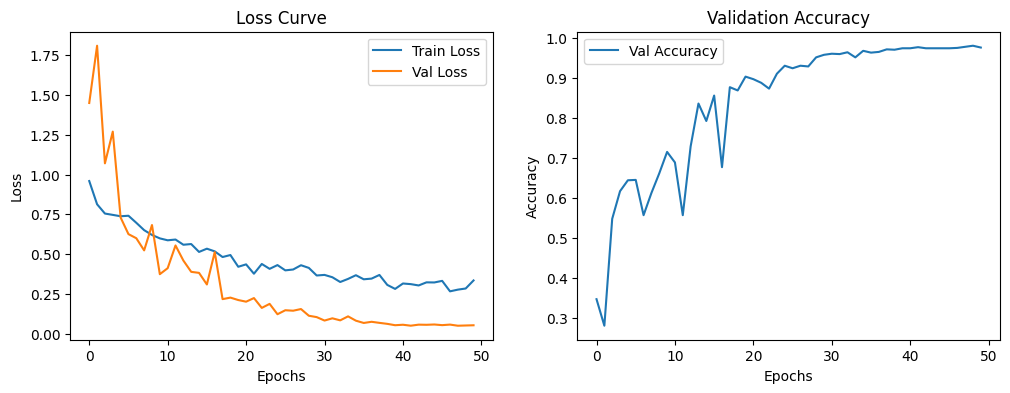

In [ ]:
plt.figure(figsize=(12,4))

#Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

#Accuracy
plt.subplot(1,2,2)
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.show()


##Evaluation

Final Evaluation: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]


Final Val Accuracy: 0.9781420765027322

Classification Report:
                          precision    recall  f1-score   support

cotton_bacterial_blight     0.9894    1.0000    0.9947        93
      cotton_curl_virus     0.9412    0.9877    0.9639        81
  cotton_fussarium_wilt     0.9540    0.9765    0.9651        85
         cotton_healthy     0.9794    0.9794    0.9794        97
       wheat_brown_rust     0.9742    0.9827    0.9784       231
          wheat_healthy     0.9938    0.9610    0.9771       333
       wheat_loose_smut     0.9778    0.9888    0.9832       178

               accuracy                         0.9781      1098
              macro avg     0.9728    0.9823    0.9774      1098
           weighted avg     0.9785    0.9781    0.9782      1098



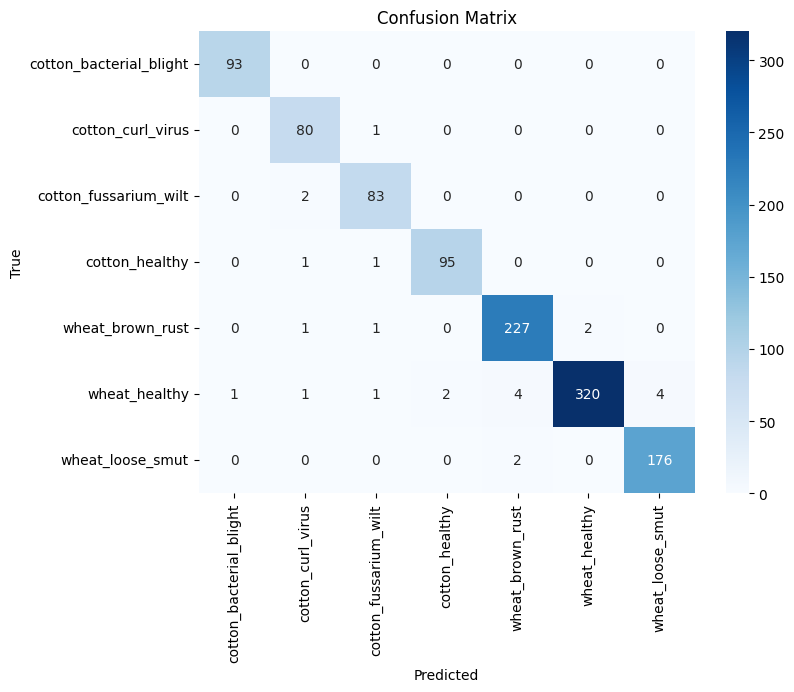

In [ ]:
#Load Best Model
ckpt = torch.load("best_advanced_crop_model.pth", map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Evaluation"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Final Val Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_names, digits=4))

#Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


##Inference

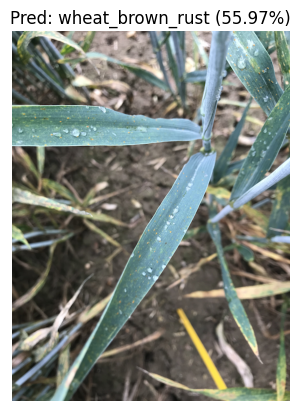

In [ ]:
def predict_image(img_path, show=True):
    img = Image.open(img_path).convert('RGB')
    x = val_transforms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)
        probs = torch.softmax(out, dim=1)[0].cpu().numpy()
        idx = int(np.argmax(probs))
    if show:
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Pred: {class_names[idx]} ({probs[idx]*100:.2f}%)")
        plt.show()
    return class_names[idx], probs

#Example
sample_img = "/content/wheat-leaf-disease/Dataset/Brown rust/BrownRust1018.png"
pred_class, pred_probs = predict_image(sample_img)


##Grad-CAM Implementation

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


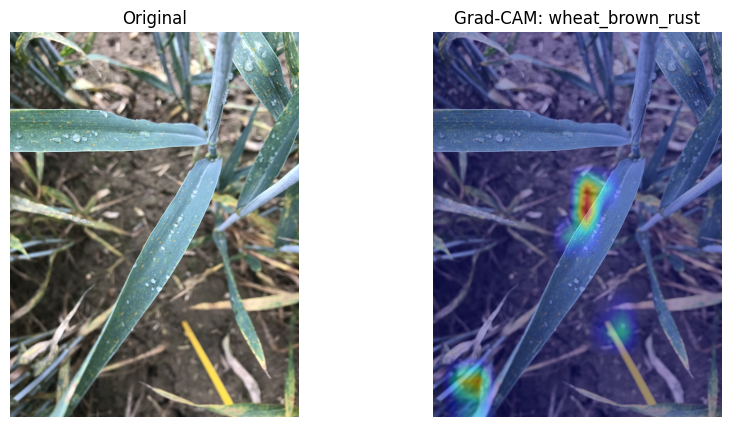

In [ ]:
def find_last_conv_layer(model):
    last_conv = None
    last_name = None
    for name, module in model.features.named_modules():
        if isinstance(module, nn.Conv2d):
            last_conv = module
            last_name = name
    return last_name, last_conv

def generate_gradcam(model, img_path, target_class=None):
    model.eval()
    last_name, last_conv = find_last_conv_layer(model)
    if last_conv is None:
        raise RuntimeError("No Conv2d layer found in model.features")

    activations, gradients = {}, {}

    def forward_hook(module, inp, out):
        activations['value'] = out.detach()

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    h_f = last_conv.register_forward_hook(forward_hook)
    h_b = last_conv.register_backward_hook(backward_hook)

    img = Image.open(img_path).convert('RGB')
    x = val_transforms(img).unsqueeze(0).to(device)
    x.requires_grad = True

    outputs = model(x)
    if target_class is None:
        target_class = int(outputs.argmax(dim=1).item())

    model.zero_grad()
    outputs[0, target_class].backward()

    act = activations['value'][0]
    grad = gradients['value'][0]
    weights = torch.mean(grad.view(grad.size(0), -1), dim=1)
    cam = torch.zeros(act.shape[1:], dtype=torch.float32).to(device)
    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = torch.relu(cam)
    cam = cam - cam.min()
    if cam.max() != 0:
        cam = cam / cam.max()

    cam_np = cam.cpu().numpy()
    h, w = img.size[1], img.size[0]
    cam_resized = cv2.resize(cam_np, (w,h))
    heatmap = cv2.applyColorMap(np.uint8(255*cam_resized), cv2.COLORMAP_JET)
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    superimposed = cv2.addWeighted(img_cv, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM: {class_names[target_class]}")
    plt.axis('off')
    plt.show()

    h_f.remove()
    h_b.remove()

#Example Grad-CAM
generate_gradcam(model, sample_img)


##Save TorchScript & Mobile Optimization

In [ ]:
#Load Checkpoint
checkpoint = torch.load("best_advanced_crop_model.pth", map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.to('cpu')
model.eval()

#TorchScript tracing
example_input = torch.randn(1, 3, 128, 128)
traced_model = torch.jit.trace(model, example_input)
torch.jit.save(traced_model, "/content/best_advanced_crop_model_traced.pt")
print("TorchScript model saved successfully!")

#Mobile optimization
optimized_model = optimize_for_mobile(traced_model)
optimized_model_path = "/content/best_advanced_crop_model_mobile.pt"
optimized_model._save_for_lite_interpreter(optimized_model_path)
print(f"Mobile-optimized model saved at: {optimized_model_path}")

#Download Model
from google.colab import files
files.download(optimized_model_path)


TorchScript model saved successfully!
Mobile-optimized model saved at: /content/best_advanced_crop_model_mobile.pt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Batch Inference + Grad-CAM Visualization

In [ ]:
import glob

#Folder containing sample images
sample_folder = "/content/sample_images"
os.makedirs(sample_folder, exist_ok=True)

#List all images
image_paths = glob.glob(os.path.join(sample_folder, "*.png")) + glob.glob(os.path.join(sample_folder, "*.jpg"))

if len(image_paths) == 0:
    print("No images found in:", sample_folder)
else:
    print(f"Found {len(image_paths)} images. Running inference...")

for img_path in image_paths:
    print(f"\nProcessing: {img_path}")
    pred_class, pred_probs = predict_image(img_path)
    generate_gradcam(model, img_path)


No images found in: /content/sample_images


MODEL TESTING


=== MODEL TESTING STARTING ===
Importing required libraries...
✅ All libraries imported successfully!
Using device: cuda

1. Initializing model...
2. Loading saved model...
✅ Model loaded successfully!
Classes: ['cotton_bacterial_blight', 'cotton_curl_virus', 'cotton_fussarium_wilt', 'cotton_healthy', 'wheat_brown_rust', 'wheat_healthy', 'wheat_loose_smut']

3. Setting up test transforms...

4. Preparing test data...
Test samples: 824

5. Running model testing...


Testing: 100%|██████████| 26/26 [00:06<00:00,  3.88it/s]



🎯 FINAL TEST ACCURACY: 98.91%

6. Generating detailed report...

📊 CLASSIFICATION REPORT:
                         precision    recall  f1-score   support

cotton_bacterial_blight       1.00      1.00      1.00        67
      cotton_curl_virus       1.00      1.00      1.00        74
  cotton_fussarium_wilt       0.98      1.00      0.99        59
         cotton_healthy       1.00      0.98      0.99        60
       wheat_brown_rust       0.97      0.99      0.98       183
          wheat_healthy       1.00      0.98      0.99       246
       wheat_loose_smut       0.99      0.99      0.99       135

               accuracy                           0.99       824
              macro avg       0.99      0.99      0.99       824
           weighted avg       0.99      0.99      0.99       824


7. Creating confusion matrix...


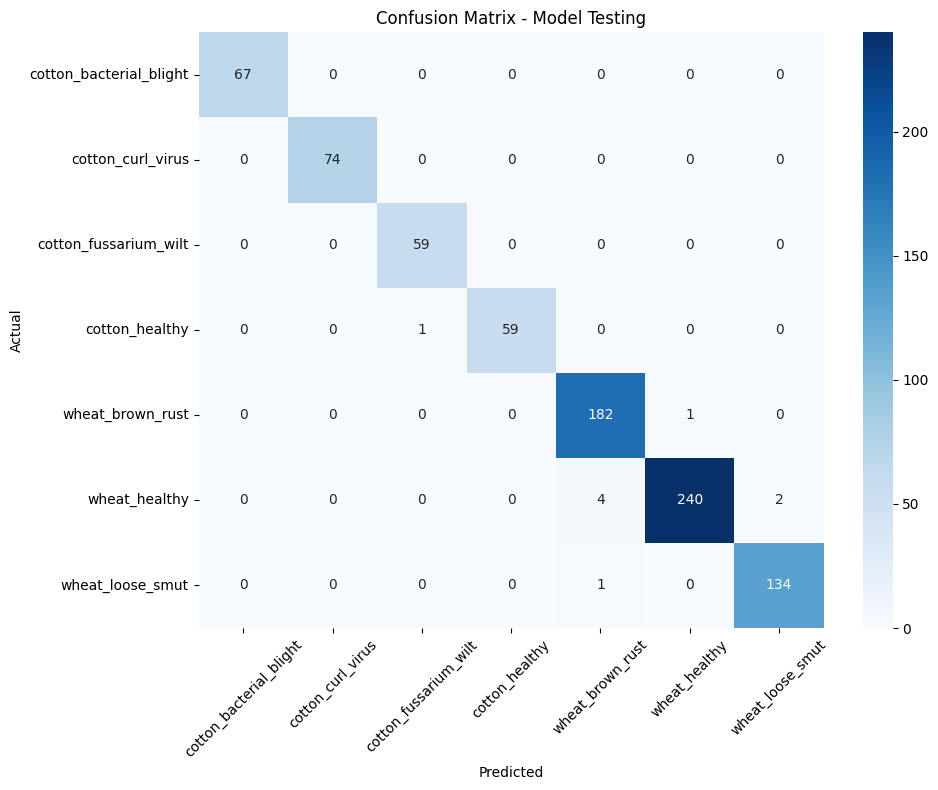


8. Single image testing setup...
📁 Colab environment detected!
You can upload an image for testing.


Saving Leaf rust_wheat_2.jpg to Leaf rust_wheat_2.jpg

🖼️ Testing uploaded image: Leaf rust_wheat_2.jpg

🎯 PREDICTION RESULT:
Class: wheat_brown_rust
Confidence: 70.70%


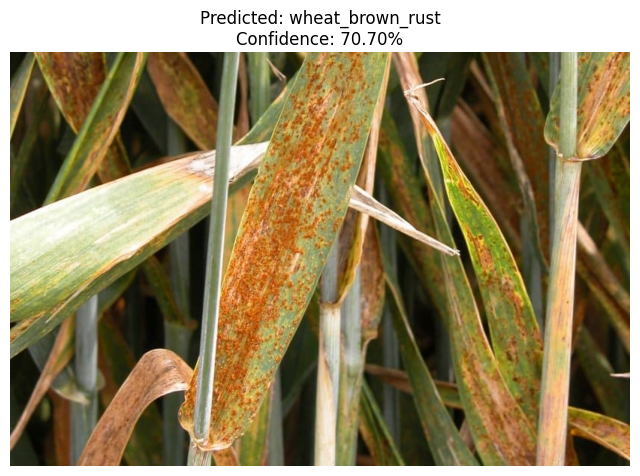


9. Calculating class-wise accuracy...

📈 CLASS-WISE PERFORMANCE:
cotton_bacterial_blight  : 100.00% (67/67)
cotton_curl_virus        : 100.00% (74/74)
cotton_fussarium_wilt    : 100.00% (59/59)
cotton_healthy           : 98.33% (59/60)
wheat_brown_rust         : 99.45% (182/183)
wheat_healthy            : 97.56% (240/246)
wheat_loose_smut         : 99.26% (134/135)

🎉 MODEL TESTING COMPLETED!
Final Test Accuracy: 98.91%
Number of Classes: 7
Test Samples: 824
Classes: ['cotton_bacterial_blight', 'cotton_curl_virus', 'cotton_fussarium_wilt', 'cotton_healthy', 'wheat_brown_rust', 'wheat_healthy', 'wheat_loose_smut']


In [ ]:
# ===============================
# MODEL TESTING SECTION
# ===============================

print("=== MODEL TESTING STARTING ===")

# Pehle necessary imports add karein
print("Importing required libraries...")
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

print("✅ All libraries imported successfully!")

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Model class ko phir se define karein (same as training)
class CropCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),

            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),

            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128,128,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.3),

            nn.Conv2d(128,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256,128), nn.ReLU(), nn.BatchNorm1d(128),
            nn.Dropout(0.4), nn.Linear(128, num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 2. Model initialize karein
print("\n1. Initializing model...")
num_classes = 7  # Aapke 7 classes hain
model = CropCNN(num_classes).to(device)

# 3. Saved model ko load karein
print("2. Loading saved model...")
checkpoint = torch.load("best_advanced_crop_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
class_names = checkpoint['class_names']
model.eval()  # Evaluation mode mein set karein
print("✅ Model loaded successfully!")
print(f"Classes: {class_names}")

# 4. Test ke liye transforms define karein
print("\n3. Setting up test transforms...")
img_size = 128
test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# 5. Test dataset banayein (combined dataset se)
print("\n4. Preparing test data...")
combined_path = "/content/combined_dataset"
test_dataset = datasets.ImageFolder(combined_path, transform=test_transforms)

# Dataset ko train/val/test mein split karein
from torch.utils.data import random_split
dataset_size = len(test_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    test_dataset, [train_size, val_size, test_size]
)

# Test loader banayein
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
print(f"Test samples: {len(test_dataset)}")

# 6. Complete testing function
def test_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    test_correct = 0
    test_total = 0

    print("\n5. Running model testing...")

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    test_accuracy = 100 * test_correct / test_total
    return test_accuracy, all_predictions, all_targets

# 7. Model test
test_accuracy, predictions, targets = test_model(model, test_loader, device)
print(f"\n🎯 FINAL TEST ACCURACY: {test_accuracy:.2f}%")

# 8. Detailed classification report
print("\n6. Generating detailed report...")
print("\n📊 CLASSIFICATION REPORT:")
print(classification_report(targets, predictions, target_names=class_names))

# 9. Confusion matrix plot
print("\n7. Creating confusion matrix...")
plt.figure(figsize=(10, 8))
cm = confusion_matrix(targets, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Model Testing')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 10. Single image test function
def predict_single_image(image_path, model, transforms, class_names, device):
    """
    Ek single image ka prediction karta hai
    """
    try:
        # Image load
        image = Image.open(image_path).convert('RGB')

        # Transform
        input_tensor = transforms(image).unsqueeze(0).to(device)

        # Prediction
        model.eval()
        with torch.no_grad():
            output = model(input_tensor)
            probabilities = torch.nn.functional.softmax(output[0], dim=0)
            confidence, predicted = torch.max(probabilities, 0)

        predicted_class = class_names[predicted.item()]
        confidence_score = confidence.item()

        return predicted_class, confidence_score, image

    except Exception as e:
        print(f"❌ Error in prediction: {e}")
        return None, None, None

# 11. Google Colab image upload
print("\n8. Single image testing setup...")

def upload_and_test():
    try:
        from google.colab import files
        print("📁 Colab environment detected!")
        print("You can upload an image for testing.")

        # Image upload
        uploaded = files.upload()

        if uploaded:
            image_path = list(uploaded.keys())[0]
            print(f"\n🖼️ Testing uploaded image: {image_path}")

            # Prediction
            predicted_class, confidence, image = predict_single_image(
                image_path, model, test_transforms, class_names, device
            )

            if predicted_class:
                print(f"\n🎯 PREDICTION RESULT:")
                print(f"Class: {predicted_class}")
                print(f"Confidence: {confidence:.2%}")

                # Image display
                plt.figure(figsize=(8, 6))
                plt.imshow(image)
                plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2%}")
                plt.axis('off')
                plt.show()
            else:
                print("❌ Prediction failed!")

    except ImportError:
        print("⚠️ Not in Colab environment - skipping image upload feature")

# Upload function
upload_and_test()

# 12. Class-wise accuracy
print("\n9. Calculating class-wise accuracy...")

# Targets aur predictions
from collections import Counter

# Actual targets  class distribution
target_counts = Counter(targets)
prediction_counts = Counter(predictions)

print("\n📈 CLASS-WISE PERFORMANCE:")
for i, class_name in enumerate(class_names):
    class_targets = [t for t in targets if t == i]
    class_predictions = [p for p, t in zip(predictions, targets) if t == i]

    if len(class_targets) > 0:
        correct = sum(1 for p, t in zip(class_predictions, class_targets) if p == t)
        accuracy = 100 * correct / len(class_targets)
        print(f'{class_name:25s}: {accuracy:.2f}% ({correct}/{len(class_targets)})')
    else:
        print(f'{class_name:25s}: No test samples')

# 13. Final summary
print("\n" + "="*50)
print("🎉 MODEL TESTING COMPLETED!")
print("="*50)
print(f"Final Test Accuracy: {test_accuracy:.2f}%")
print(f"Number of Classes: {len(class_names)}")
print(f"Test Samples: {len(test_dataset)}")
print(f"Classes: {class_names}")
print("="*50)

